In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import copy
torch.manual_seed(42)
np.random.seed(42)

class CircleTaskDistribution:
    def __init__(self, k_shot=10, q_query=15):
        self.k_shot = k_shot
        self.q_query = q_query
        self.radius = 2.0
        self.range_min = -5.0
        self.range_max = 5.0
        self.center_range = 3.0

    def sample_task(self):
        cx = np.random.uniform(-self.center_range, self.center_range)
        cy = np.random.uniform(-self.center_range, self.center_range)
        return (cx, cy)

    def get_data(self, center, num_samples):
        cx, cy = center
        x = torch.FloatTensor(num_samples, 2).uniform_(self.range_min, self.range_max)
        dist_sq = (x[:, 0] - cx)**2 + (x[:, 1] - cy)**2
        y = (dist_sq < self.radius**2).float().unsqueeze(1)
        return x, y

    def get_task_batch(self):
        center = self.sample_task()
        support_x, support_y = self.get_data(center, self.k_shot)
        query_x, query_y = self.get_data(center, self.q_query)
        return support_x, support_y, query_x, query_y, center

In [8]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x, params=None):
        if params is None:
            return self.net(x)
        x = torch.nn.functional.linear(x, params['net.0.weight'], params['net.0.bias'])
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.linear(x, params['net.2.weight'], params['net.2.bias'])
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.linear(x, params['net.4.weight'], params['net.4.bias'])
        x = torch.sigmoid(x)
        return x

def get_params(model):
    return {name: param for name, param in model.named_parameters()}

In [9]:
task_dist = CircleTaskDistribution()
maml_model = SimpleMLP()
meta_optimizer = optim.Adam(maml_model.parameters(), lr=0.001)
inner_lr = 0.1
loss_fn = nn.BCELoss()

print("Starting MAML Training (2000 epochs)...")

maml_losses = []

for epoch in range(2001):
    sup_x, sup_y, q_x, q_y, _ = task_dist.get_task_batch()
    weights = get_params(maml_model)
    sup_pred = maml_model(sup_x, params=weights)
    inner_loss = loss_fn(sup_pred, sup_y)
    grads = torch.autograd.grad(inner_loss, weights.values(), create_graph=True)
    fast_weights = {}
    for (name, param), grad in zip(weights.items(), grads):
        fast_weights[name] = param - inner_lr * grad
    q_pred = maml_model(q_x, params=fast_weights)
    meta_loss = loss_fn(q_pred, q_y)
    meta_optimizer.zero_grad()
    meta_loss.backward()
    meta_optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch}: Meta Loss = {meta_loss.item():.4f}")
        maml_losses.append(meta_loss.item())

print("MAML Training Complete.")

Starting MAML Training (2000 epochs)...
Epoch 0: Meta Loss = 0.3555
Epoch 200: Meta Loss = 0.6035
Epoch 400: Meta Loss = 0.7599
Epoch 600: Meta Loss = 0.2518
Epoch 800: Meta Loss = 0.0818
Epoch 1000: Meta Loss = 0.5201
Epoch 1200: Meta Loss = 0.1547
Epoch 1400: Meta Loss = 0.0805
Epoch 1600: Meta Loss = 0.2371
Epoch 1800: Meta Loss = 0.2570
Epoch 2000: Meta Loss = 0.5361
MAML Training Complete.


In [10]:
baseline_model = SimpleMLP()
baseline_optimizer = optim.Adam(baseline_model.parameters(), lr=0.001)
baseline_loss_fn = nn.BCELoss()

print("Starting Baseline Training (2000 epochs)...")

for epoch in range(2001):
    b_x, b_y, _, _, _ = task_dist.get_task_batch()
    preds = baseline_model(b_x)
    loss = baseline_loss_fn(preds, b_y)

    baseline_optimizer.zero_grad()
    loss.backward()
    baseline_optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch}: Baseline Loss = {loss.item():.4f}")

print("Baseline Training Complete.")

Starting Baseline Training (2000 epochs)...
Epoch 0: Baseline Loss = 0.6438
Epoch 200: Baseline Loss = 0.4396
Epoch 400: Baseline Loss = 0.3885
Epoch 600: Baseline Loss = 0.2651
Epoch 800: Baseline Loss = 0.6778
Epoch 1000: Baseline Loss = 0.1798
Epoch 1200: Baseline Loss = 0.1239
Epoch 1400: Baseline Loss = 0.5229
Epoch 1600: Baseline Loss = 0.3396
Epoch 1800: Baseline Loss = 0.4636
Epoch 2000: Baseline Loss = 0.4398
Baseline Training Complete.


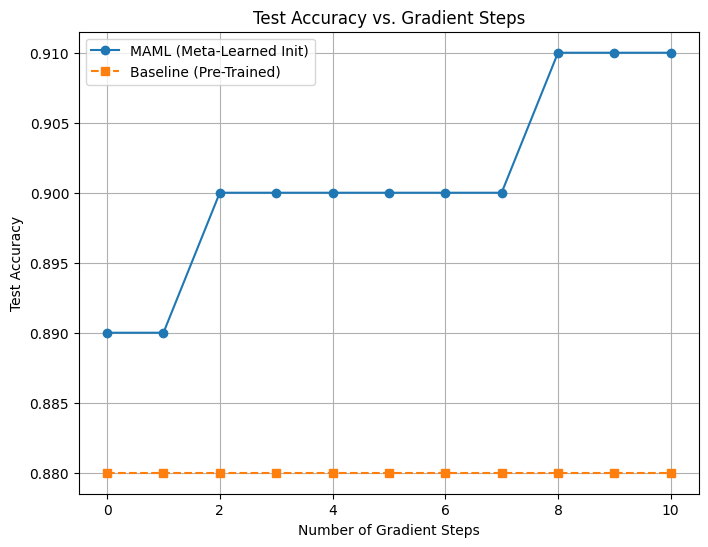

In [11]:
def fine_tune_and_evaluate(model, steps=10, lr=0.1):
    test_task = CircleTaskDistribution(k_shot=10, q_query=100)
    sup_x, sup_y, test_x, test_y, _ = test_task.get_task_batch()
    temp_model = copy.deepcopy(model)
    optimizer = optim.SGD(temp_model.parameters(), lr=lr)
    loss_fn = nn.BCELoss()

    accuracies = []
    for step in range(steps + 1):
        with torch.no_grad():
            preds = temp_model(test_x)
            predicted_labels = (preds > 0.5).float()
            acc = (predicted_labels == test_y).float().mean().item()
            accuracies.append(acc)

        if step < steps:
            temp_model.train()
            sup_preds = temp_model(sup_x)
            loss = loss_fn(sup_preds, sup_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    return accuracies

steps = 10
maml_accs = fine_tune_and_evaluate(maml_model, steps=steps)
baseline_accs = fine_tune_and_evaluate(baseline_model, steps=steps)

plt.figure(figsize=(8, 6))
plt.plot(range(steps + 1), maml_accs, 'o-', label='MAML (Meta-Learned Init)')
plt.plot(range(steps + 1), baseline_accs, 's--', label='Baseline (Pre-Trained)')
plt.title('Test Accuracy vs. Gradient Steps')
plt.xlabel('Number of Gradient Steps')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

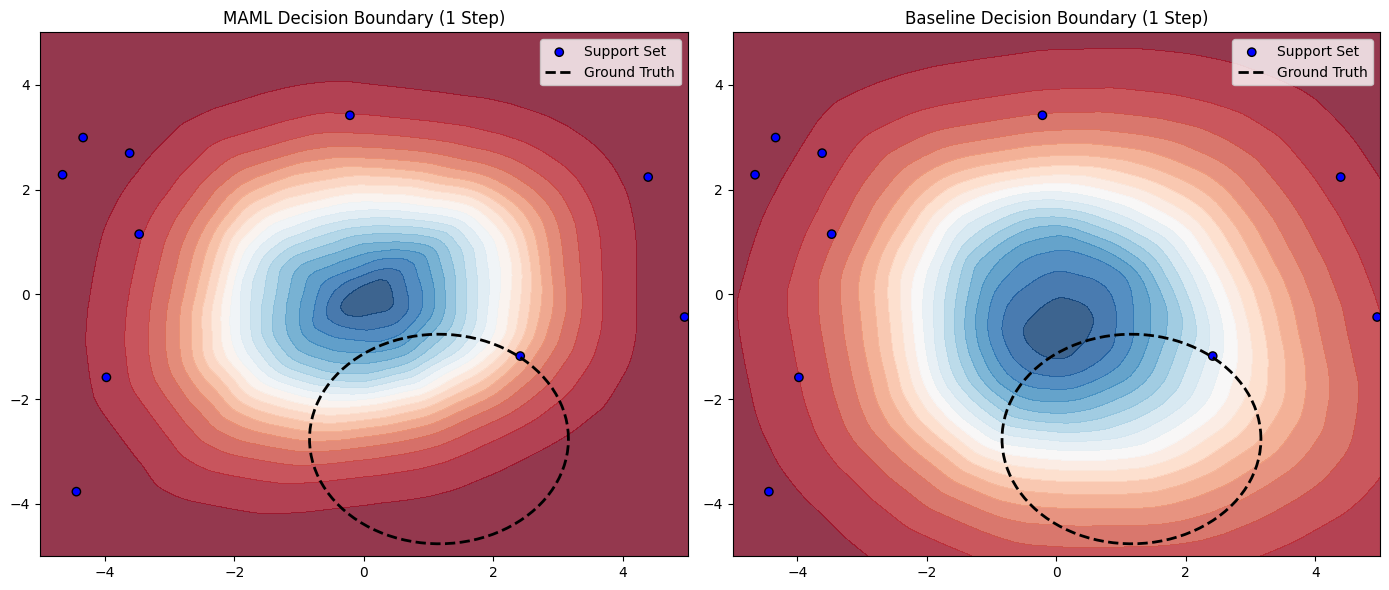

In [12]:
def plot_decision_boundary(model, ax, title):
    x_range = np.linspace(-5, 5, 100)
    y_range = np.linspace(-5, 5, 100)
    xx, yy = np.meshgrid(x_range, y_range)
    grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
    with torch.no_grad():
        preds = model(grid_tensor).reshape(xx.shape)
    contour = ax.contourf(xx, yy, preds, levels=20, cmap='RdBu', alpha=0.8)
    return contour
vis_task = CircleTaskDistribution(k_shot=10)
sup_x, sup_y, _, _, center = vis_task.get_task_batch()
cx, cy = center
r = 2.0
maml_vis = copy.deepcopy(maml_model)
maml_opt = optim.SGD(maml_vis.parameters(), lr=0.1)

loss = nn.BCELoss()(maml_vis(sup_x), sup_y)
maml_opt.zero_grad()
loss.backward()
maml_opt.step()


base_vis = copy.deepcopy(baseline_model)
base_opt = optim.SGD(base_vis.parameters(), lr=0.1)

loss = nn.BCELoss()(base_vis(sup_x), sup_y)
base_opt.zero_grad()
loss.backward()
base_opt.step()


fig, axes = plt.subplots(1, 2, figsize=(14, 6))


plot_decision_boundary(maml_vis, axes[0], "MAML (1 Step)")
axes[0].set_title("MAML Decision Boundary (1 Step)")
axes[0].scatter(sup_x[:,0], sup_x[:,1], c=sup_y.flatten(), cmap='bwr', edgecolors='k', label='Support Set')

plot_decision_boundary(base_vis, axes[1], "Baseline (1 Step)")
axes[1].set_title("Baseline Decision Boundary (1 Step)")
axes[1].scatter(sup_x[:,0], sup_x[:,1], c=sup_y.flatten(), cmap='bwr', edgecolors='k', label='Support Set')


theta = np.linspace(0, 2*np.pi, 100)
circle_x = cx + r * np.cos(theta)
circle_y = cy + r * np.sin(theta)

for ax in axes:
    ax.plot(circle_x, circle_y, 'k--', linewidth=2, label='Ground Truth')
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.legend()

plt.tight_layout()
plt.show()